In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from scipy.optimize import minimize

In [2]:
file_path = "Price History_IVV_US_Equity.xlsx"
df = pd.read_excel(file_path, index_col=0, parse_dates=True)

In [3]:
print(df.head())

                Close   Net      %Chg    Open       Low    High   Volume  \
Exchange Date                                                              
2024-12-13     607.24 -0.11 -0.000181  609.44  605.8278  610.15  9729091   
2024-12-12     607.35 -3.24 -0.005306  609.63  607.3500  610.17  5830787   
2024-12-11     610.59  4.67  0.007707  608.80  608.5080  611.48  4892064   
2024-12-10     605.92 -1.76 -0.002896  608.39  605.1600  608.72  4489053   
2024-12-09     607.68 -3.15 -0.005157  610.75  607.0900  610.85  2973765   

               Turnover - USD  
Exchange Date                  
2024-12-13       5.909573e+09  
2024-12-12       3.545192e+09  
2024-12-11       2.986816e+09  
2024-12-10       2.723671e+09  
2024-12-09       1.809882e+09  


In [4]:
# Ensure 'Close' column exists before computing log returns
if 'Close' in df.columns:
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
else:
    print("Error: 'Close' column is missing. Check dataset structure.")

# Drop NaN values to avoid issues
df.dropna(inplace=True)


In [19]:
# Keep only data from 2022-10-27 onward
df = df[df.index >= "2022-10-27"]

# Verify that both datasets have the same start date now
print("Updated GARCH/Heston Index Range:", df.index.min(), "to", df_garch_heston.index.max())
print("LSTM Predictions Index Range:", df_lstm_pred.index.min(), "to", df_lstm_pred.index.max())


NameError: name 'df_garch_heston' is not defined

In [5]:
# Ensure 'Log_Returns' exists before computing volatility
if 'Log_Returns' not in df.columns:
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Compute rolling volatility (30-day window, annualized)
df['Rolling_Volatility'] = df['Log_Returns'].rolling(window=30).std() * np.sqrt(252)

# Drop NaN values to clean data
df.dropna(inplace=True)

# Save the updated DataFrame
df.to_csv("processed_IVV_data.csv")


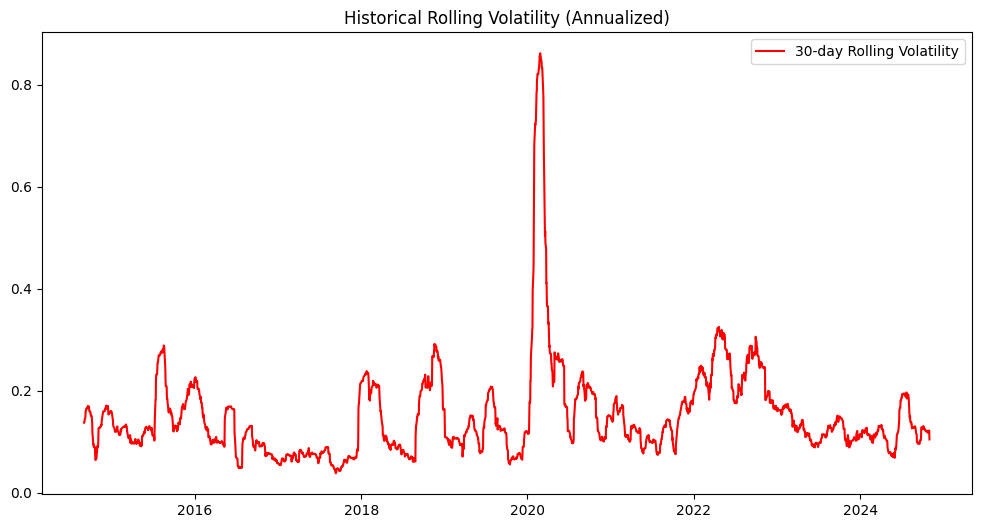

In [6]:
# Ensure data is sorted by date
df = df.sort_index()

# Rescale log returns to avoid numerical issues
df['Scaled_Log_Returns'] = df['Log_Returns'] * 100  # Scale up to improve model convergence

# Plot historical volatility
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Rolling_Volatility'], label="30-day Rolling Volatility", color="red")
plt.title("Historical Rolling Volatility (Annualized)")
plt.legend()
plt.show()

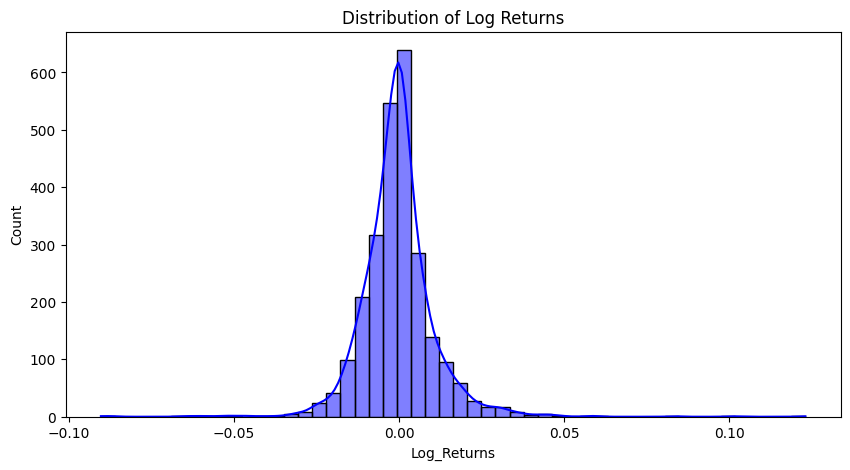

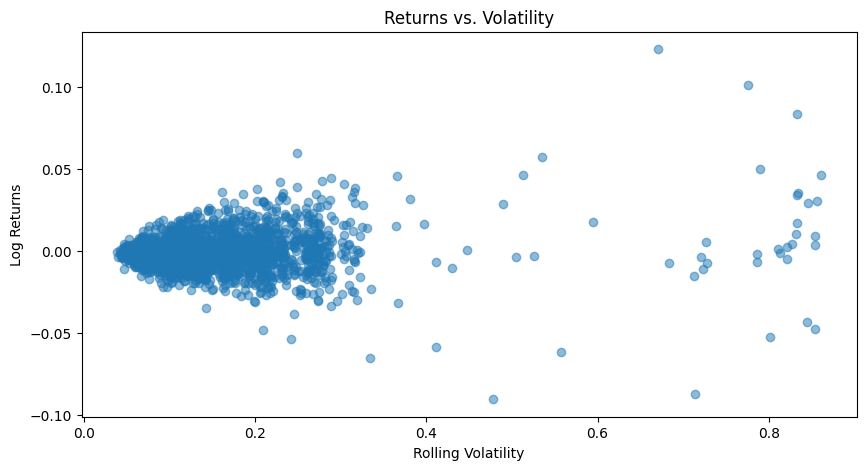

In [7]:
# Histogram of log returns
plt.figure(figsize=(10,5))
sns.histplot(df['Log_Returns'], bins=50, kde=True, color="blue")
plt.title("Distribution of Log Returns")
plt.show()

# Scatter plot of returns vs. past volatility
plt.figure(figsize=(10,5))
plt.scatter(df['Rolling_Volatility'], df['Log_Returns'], alpha=0.5)
plt.title("Returns vs. Volatility")
plt.xlabel("Rolling Volatility")
plt.ylabel("Log Returns")
plt.show()


In [8]:
# === GARCH(1,1) Model ===
print("\nFitting GARCH(1,1) Model...")
garch_model = arch_model(df['Scaled_Log_Returns'].dropna(), vol='Garch', p=1, q=1)
garch_results = garch_model.fit()
print(garch_results.summary())


Fitting GARCH(1,1) Model...
Iteration:      1,   Func. Count:      6,   Neg. LLF: 29239.863673792614
Iteration:      2,   Func. Count:     17,   Neg. LLF: 14720.155789765027
Iteration:      3,   Func. Count:     27,   Neg. LLF: 5341.194763379119
Iteration:      4,   Func. Count:     34,   Neg. LLF: 5671.506153674654
Iteration:      5,   Func. Count:     41,   Neg. LLF: 3303.6559236445037
Iteration:      6,   Func. Count:     47,   Neg. LLF: 3283.771336503485
Iteration:      7,   Func. Count:     52,   Neg. LLF: 3283.7712547816623
Iteration:      8,   Func. Count:     57,   Neg. LLF: 3283.771247856857
Iteration:      9,   Func. Count:     61,   Neg. LLF: 3283.7712478568933
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3283.771247856857
            Iterations: 9
            Function evaluations: 61
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:     Scaled_Log_Re

In [9]:
# Convert back to original scale
df['GARCH_Volatility'] = garch_results.conditional_volatility / 100 * np.sqrt(252)  # Annualized

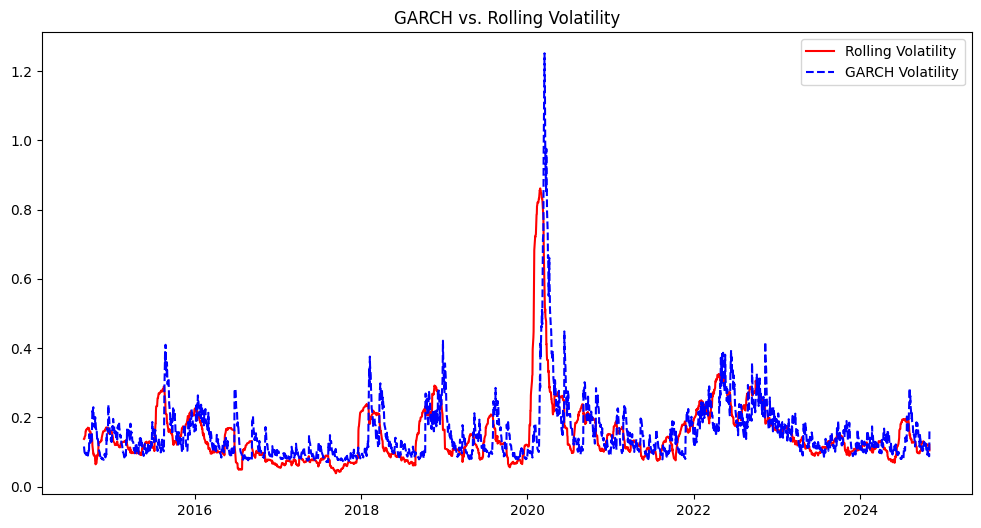

In [10]:
# Plot GARCH vs. Rolling Volatility
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Rolling_Volatility'], label="Rolling Volatility", color="red")
plt.plot(df.index, df['GARCH_Volatility'], label="GARCH Volatility", color="blue", linestyle="dashed")
plt.title("GARCH vs. Rolling Volatility")
plt.legend()
plt.show()

In [11]:
def heston_loss(params, log_returns):
    """Loss function for calibrating Heston model parameters."""
    kappa, theta, sigma, rho, v0 = params
    
    dt = 1/252  # Daily time step
    n = len(log_returns)

    # Initialize arrays
    v_t = np.full(n, v0)
    s_t = np.exp(np.cumsum(log_returns))

    for t in range(1, n):  # Ensure correct loop range
        dz1, dz2 = np.random.normal(0, np.sqrt(dt), 2)
        dz2 = rho * dz1 + np.sqrt(1 - rho**2) * dz2
        v_t[t] = np.abs(v_t[t-1] + kappa * (theta - v_t[t-1]) * dt + sigma * np.sqrt(v_t[t-1]) * dz1)
        s_t[t] = s_t[t-1] * np.exp(-0.5 * v_t[t-1] * dt + np.sqrt(v_t[t-1] * dt) * dz2)

    # Ensure correct array length for loss function
    log_return_estimates = np.log(s_t[1:] / s_t[:-1])
    return np.mean((log_returns[1:] - log_return_estimates)**2)  # Use matching lengths


In [12]:
# Initial parameter guesses for Heston Model
initial_params = [2, 0.02, 0.1, -0.5, 0.02]
result = minimize(heston_loss, initial_params, args=(df['Log_Returns'].values,), method='Nelder-Mead')

In [13]:
# Extract optimized parameters
kappa_opt, theta_opt, sigma_opt, rho_opt, v0_opt = result.x
print("\nHeston Model Parameters:")
print(f"kappa: {kappa_opt}, theta: {theta_opt}, sigma: {sigma_opt}, rho: {rho_opt}, v0: {v0_opt}")


Heston Model Parameters:
kappa: 1.9875, theta: 0.020075000000000003, sigma: 0.10037499999999999, rho: -0.5018750000000001, v0: 0.020825000000000003


In [14]:
# Compute Heston-implied volatility
df['Heston_Volatility'] = np.sqrt(v0_opt) * np.sqrt(252)


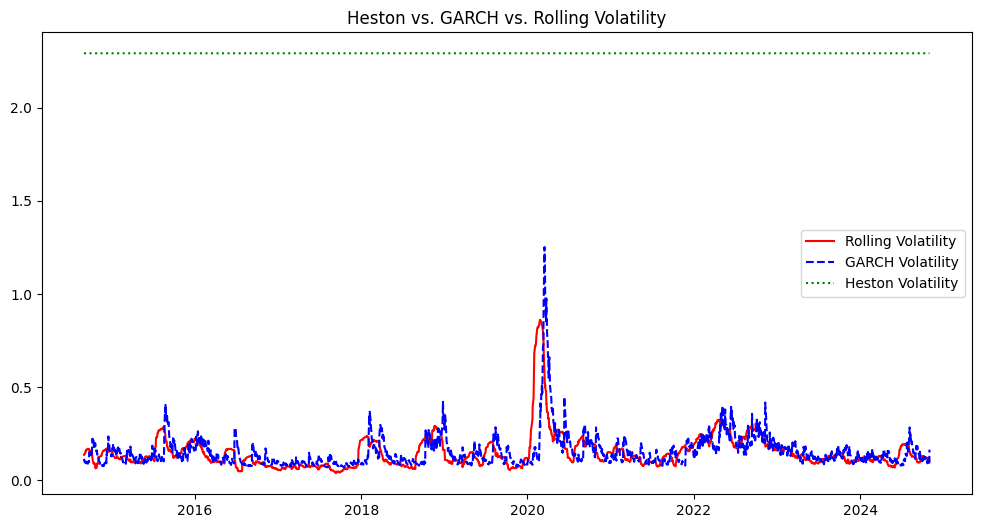

In [15]:
# Plot Heston vs. GARCH vs. Rolling Volatility
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Rolling_Volatility'], label="Rolling Volatility", color="red")
plt.plot(df.index, df['GARCH_Volatility'], label="GARCH Volatility", color="blue", linestyle="dashed")
plt.plot(df.index, df['Heston_Volatility'], label="Heston Volatility", color="green", linestyle="dotted")
plt.title("Heston vs. GARCH vs. Rolling Volatility")
plt.legend()
plt.show()


In [16]:
df.to_csv("volatility_predictions.csv")
print("Volatility predictions saved successfully!")


Volatility predictions saved successfully!
